In [12]:
from TriggerStudyBinaries_v3 import *

AllEventsBackground = EventGenerator(["19_19.5"], split=1, force_inject=1, prior = 0, seed = 42)

Let's look at what *kind* of injected particles get triggered to maybe get a feeling what the NN identifies

In [3]:
Classifier = NNClassifier("minimal_conv2d_cut_1.00VEM/model_2")

not_triggered, triggered = [], []
n_traces = 0

for batch in range(AllEventsBackground.__len__()):

    print(f"Fetching batch {batch + 1}/{AllEventsBackground.__len__()}: {100 * (batch/AllEventsBackground.__len__()):.2f}%", end="...\r")

    traces, labels = AllEventsBackground.__getitem__(batch, full_trace=True)

    for trace in traces:

        n_traces += 1

        for i in AllEventsBackground.__sliding_window__(trace):

            start, stop = i, i + AllEventsBackground.window_length
            window, n_sig = trace.get_trace_window((start, stop))

            if Classifier(window):
                triggered.append(np.mean(np.sum(trace.Injected, axis = 1)))
                break

        else: not_triggered.append(np.mean(np.sum(trace.Injected, axis = 1)))

print()
print(f"{n_traces} traces raised")
print(f"{len(triggered)} false positives found")
print(f"{len(not_triggered)} true negatives found")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 40, 1)          10        
                                                                 
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 2)                 82        
                                                                 
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________

Fetching batch 4322/4322: 99.98%...
4322 traces raised
1946 false positives found
2376 true negatives found


In [5]:
OldClassifier = TriggerClassifier()

old_not_triggered, old_triggered = [], []
old_n_traces = 0

random.seed(42)
np.random.seed(42)

for batch in range(AllEventsBackground.__len__()):

    print(f"Fetching batch {batch + 1}/{AllEventsBackground.__len__()}: {100 * (batch/AllEventsBackground.__len__()):.2f}%", end="...\r")

    traces, labels = AllEventsBackground.__getitem__(batch, full_trace=True)

    for trace in traces:

        old_n_traces += 1

        for i in AllEventsBackground.__sliding_window__(trace):

            start, stop = i, i + AllEventsBackground.window_length
            window, n_sig = trace.get_trace_window((start, stop))

            if OldClassifier(window):
                old_triggered.append(np.mean(np.sum(trace.Injected, axis = 1)))
                break

        else: old_not_triggered.append(np.mean(np.sum(trace.Injected, axis = 1)))

print()
print(f"{old_n_traces} traces raised")
print(f"{len(old_triggered)} false positives found")
print(f"{len(old_not_triggered)} true negatives found")

Fetching batch 4322/4322: 99.98%......................................................
4322 traces raised
722 false positives found
3600 true negatives found


Compare the two classifiers:

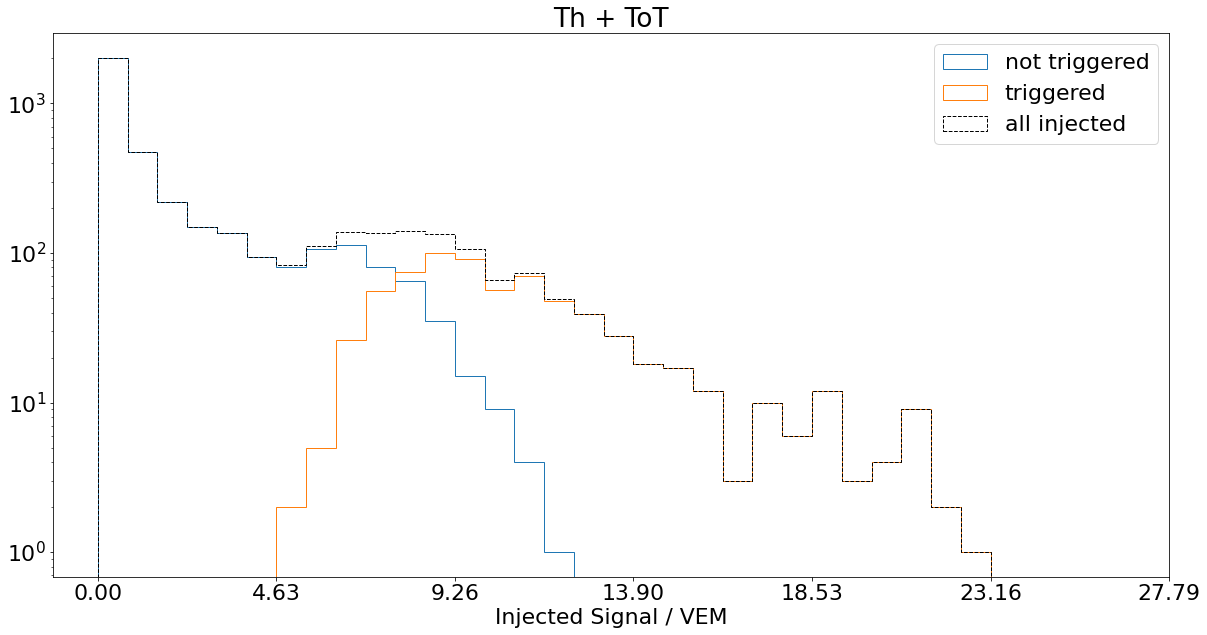

In [6]:
plt.rcParams['figure.figsize'] = [20, 10]

s_max = 5000

def change_labels_to_VEM():

    print()
    ticks, labels = plt.xticks()
    labels = [f"{item / GLOBAL.ADC_to_VEM:.2f}" for item in ticks]
    plt.xticks(ticks[1:], labels[1:])

# plt.title("Neural network, cut to 1 VEM")
# plt.hist(not_triggered, histtype="step", bins = 30, label="not triggered", range = (0,s_max))
# plt.hist(triggered, histtype="step", bins = 30, label="triggered", range = (0,s_max))
# plt.hist(triggered + not_triggered, histtype="step", bins = 30, label="all injected", color = "k", ls="--", range = (0,s_max))
# plt.xlabel("Injected Signal / VEM")
# plt.yscale("log")
# plt.axvline(GLOBAL.ADC_to_VEM, ls = "--", lw = 2)
# change_labels_to_VEM()
# plt.legend()

plt.figure()
plt.title("Th + ToT")
plt.hist(old_not_triggered, histtype="step", bins = 30, label="not triggered", range = (0,s_max))
plt.hist(old_triggered, histtype="step", bins = 30, label="triggered", range = (0,s_max))
plt.hist(old_triggered + old_not_triggered, histtype="step", bins = 30, label="all injected", color = "k", ls="--", range = (0,s_max))
plt.xlabel("Injected Signal / VEM")
plt.yscale("log")
change_labels_to_VEM()
plt.legend()

# **CONCLUSION:**

* Even higher cut? Let's try this out

In [8]:
NewClassifier = NNClassifier("one_layer_conv2d_2.00VEM/ensemble_1/model_4/model_5")
new_not_triggered, new_triggered = [], []
new_n_traces = 0

random.seed(42)
np.random.seed(42)

for batch in range(AllEventsBackground.__len__()):

    print(f"Fetching batch {batch + 1}/{AllEventsBackground.__len__()}: {100 * (batch/AllEventsBackground.__len__()):.2f}%", end="...\r")

    traces, labels = AllEventsBackground.__getitem__(batch, full_trace=True)

    for trace in traces:

        new_n_traces += 1

        for i in AllEventsBackground.__sliding_window__(trace):

            start, stop = i, i + AllEventsBackground.window_length
            window, n_sig = trace.get_trace_window((start, stop))

            if NewClassifier(window):
                new_triggered.append(np.mean(np.sum(trace.Injected, axis = 1)))
                break

        else: new_not_triggered.append(np.mean(np.sum(trace.Injected, axis = 1)))

print()
print(f"{new_n_traces} traces raised")
print(f"{len(new_triggered)} false positives found")
print(f"{len(new_not_triggered)} true negatives found")

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 1, 40, 1)          10        
                                                                 
 flatten_20 (Flatten)        (None, 40)                0         
                                                                 
 dense_20 (Dense)            (None, 2)                 82        
                                                                 
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________

Fetching batch 4322/4322: 99.98%...
4322 traces raised
1607 false positives found
2715 true negatives found


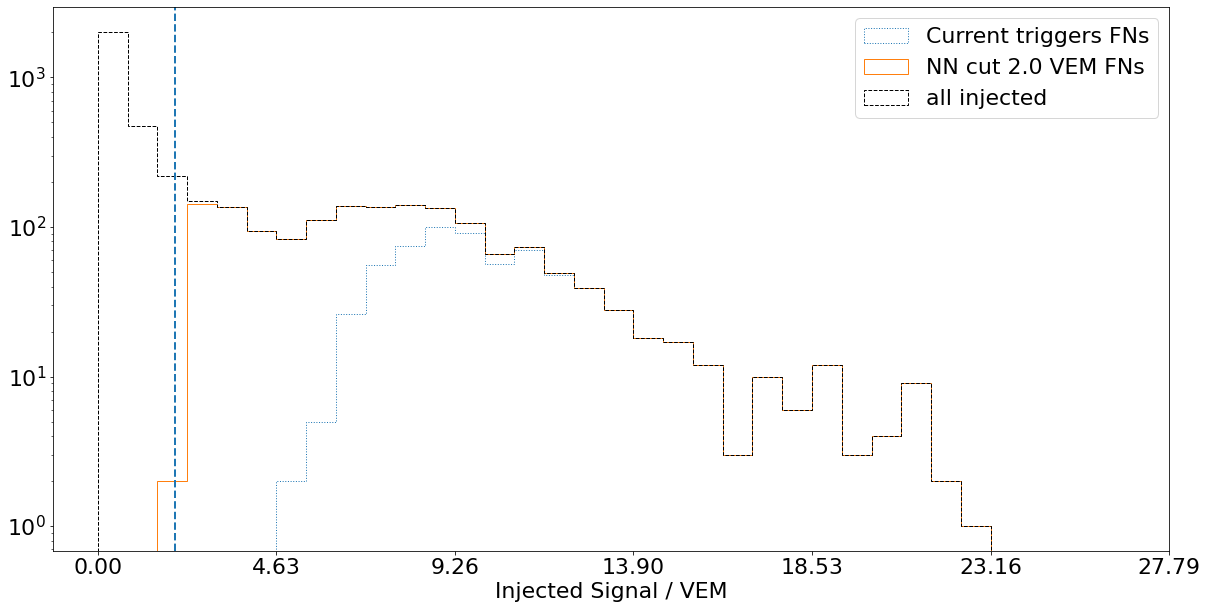

In [9]:
plt.hist(old_triggered, histtype="step", bins = 30, label="Current triggers FNs", range = (0,s_max), ls = ":")
plt.hist(new_triggered, histtype="step", bins = 30, label="NN cut 2.0 VEM FNs", range = (0,s_max), ls = "solid")
plt.hist(old_triggered + old_not_triggered, histtype="step", bins = 30, label="all injected", color = "k", ls="--", range = (0,s_max))
plt.xlabel("Injected Signal / VEM")
plt.axvline(2 * GLOBAL.ADC_to_VEM, ls = "--", lw = 2)
plt.yscale("log")
change_labels_to_VEM()
plt.legend()

Seems to work... how far can we go?

In [14]:
NewClassifier = NNClassifier("one_layer_conv2d_4.63VEM/model_2")
new_not_triggered, new_triggered = [], []
new_n_traces = 0

random.seed(42)
np.random.seed(42)

for batch in range(AllEventsBackground.__len__()):

    print(f"Fetching batch {batch + 1}/{AllEventsBackground.__len__()}: {100 * (batch/AllEventsBackground.__len__()):.2f}%", end="...\r")

    traces, labels = AllEventsBackground.__getitem__(batch, full_trace=True)

    for trace in traces:

        new_n_traces += 1

        for i in AllEventsBackground.__sliding_window__(trace):

            start, stop = i, i + AllEventsBackground.window_length
            window, n_sig = trace.get_trace_window((start, stop))

            if NewClassifier(window):
                new_triggered.append(np.mean(np.sum(trace.Injected, axis = 1)))
                break

        else: new_not_triggered.append(np.mean(np.sum(trace.Injected, axis = 1)))

print()
print(f"{new_n_traces} traces raised")
print(f"{len(new_triggered)} false positives found")
print(f"{len(new_not_triggered)} true negatives found")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 40, 1)          10        
                                                                 
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 2)                 82        
                                                                 
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________

Fetching batch 4322/4322: 99.98%...
4322 traces raised
1214 false positives found
3108 true negatives found


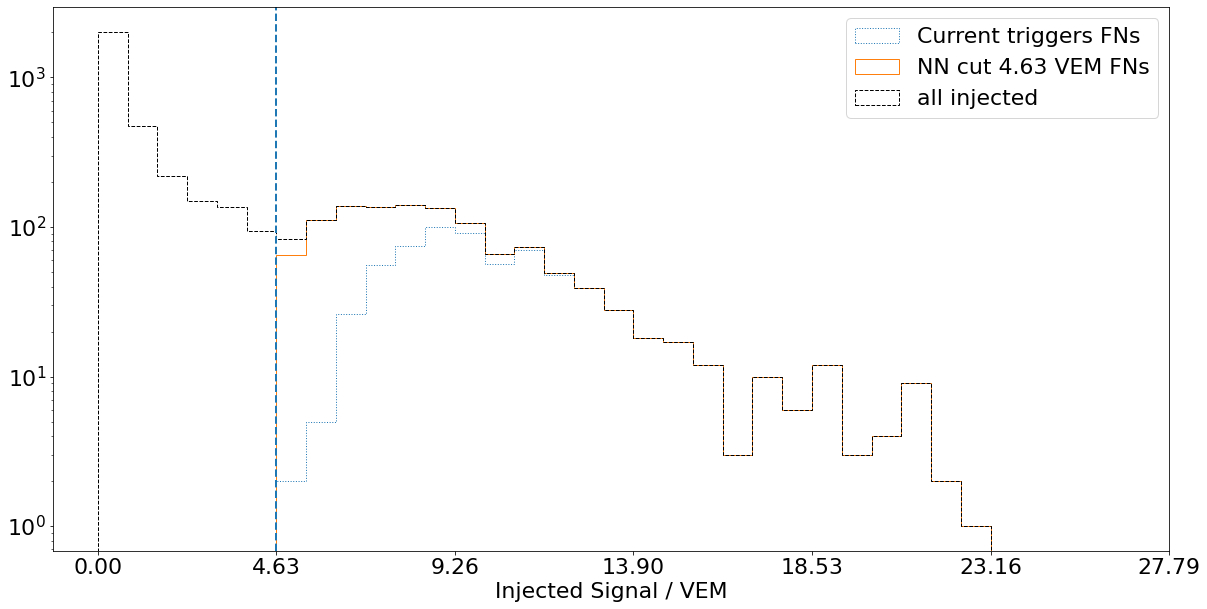

In [16]:
plt.hist(old_triggered, histtype="step", bins = 30, label="Current triggers FNs", range = (0,s_max), ls = ":")
plt.hist(new_triggered, histtype="step", bins = 30, label="NN cut 4.63 VEM FNs", range = (0,s_max), ls = "solid")
plt.hist(old_triggered + old_not_triggered, histtype="step", bins = 30, label="all injected", color = "k", ls="--", range = (0,s_max))
plt.xlabel("Injected Signal / VEM")
plt.axvline(4.63 * GLOBAL.ADC_to_VEM, ls = "--", lw = 2)
plt.yscale("log")
change_labels_to_VEM()
plt.legend()